# Imports

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import glob
from ipywidgets import interact

# Dataset

In [2]:
images = []
ilabels = []
for img in glob.glob("Datasets\I_SI_01\*.bmp"):
    n = cv2.imread(img, 0)
    images.append(n)
    ilabels.append(img)
images_sorted = [i for _,i in sorted(zip(ilabels,images))]

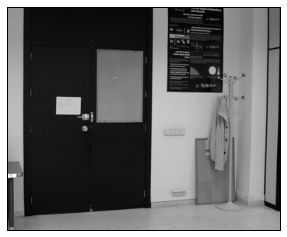

In [3]:
def view_image(i = 0):
    plt.imshow(images_sorted[i], cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

w = interact(view_image, i=(0, len(images_sorted)-1))

In [174]:
file = 'Ball1'
cap0 = cv2.VideoCapture('Datasets\Stereo Dataset\\'+str(file)+' C1.avi')
cap1 = cv2.VideoCapture('Datasets\Stereo Dataset\\'+str(file)+' C2.avi')
images0 = []
images1 = []
i = 0
while(i < 100):
    ret, frame0 = cap0.read()
    ret, frame1 = cap1.read()
    if(frame0 is None or frame1 is None):
        break
    frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
    frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    images0.append(frame0)  
    images1.append(frame1)
    i += 1
    
cap0.release()
cap1.release()
cv2.destroyAllWindows()

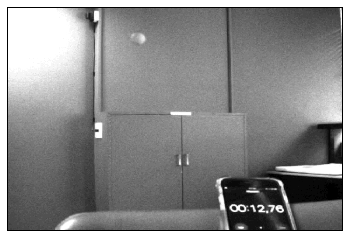

In [175]:
def view_image(i = 0):
    plt.imshow(images0[i], cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

w = interact(view_image, i=(0, len(images0)-1))

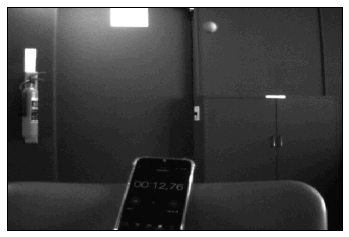

In [6]:
def view_image(i = 0):
    plt.imshow(images1[i], cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

w = interact(view_image, i=(0, len(images1)-1))

In [7]:
print(images_sorted[0].shape)
print(images0[0].shape)
print(images1[0].shape)

(288, 352)
(480, 720)
(480, 720)


# Functions

### Background Subtraction

#### Simple

In [74]:
class background_sub_simple:
    
    def __init__(self, background_samples):
        #background model initialisation
        self.background = background_samples[0]
        for i in range(0, len(background_samples)-1):
            self.background = cv2.addWeighted(self.background,(i+1)/(i+2),background_samples[i+1],1/(i+2),0)
    
    def get_background(self):
        #get background image
        return self.background
    
    def subtract(self, image):
        #background subtract an image
        background_subbed = cv2.absdiff(image, self.background)
        return background_subbed

#### MOG

In [9]:
class background_sub_mog:
    def __init__(self, history):
        #mog2 object initialisation
        self.background_sub = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
        self.background_sub.setHistory(history)
        
    def get_background_subtractor(self):
        #get mog2 object
        return self.background_sub
    
    def subtract(self, image):
        #background subtract an image
        return self.background_sub.apply(image)

### Thresholding

In [10]:
def thresh(image, threshtype):     # threshtype 0 = standard, threshtype 1 = adaptive, threshtype 2 = otsu (default 0)
    if(threshtype == 1):
        image_threshed = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 39, -15)
    elif(threshtype == 2):
        ret, image_threshed = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        ret, image_threshed = cv2.threshold(image, 15, 255, cv2.THRESH_BINARY)
    return np.array(image_threshed)

### Smoothing

In [11]:
def smooth(image, filtertype):     # filtertype 0 = gaussian, filtertype 1 = median, filtertype 2 = bilateral (default 0)
    if(filtertype == 1):
        image_smoothed = cv2.medianBlur(image, 5)
    elif(filtertype == 2):
        image_smoothed = cv2.bilateralFilter(image, 9, 100, 100)
    else:
        image_smoothed = cv2.GaussianBlur(image, (5, 5), 0)
    return np.array(image_smoothed)

### Morphological Transformations

#### Erosion

In [12]:
def erode(image, kernel_size): 
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    image_eroded = cv2.erode(image, kernel, iterations = 1)
    return np.array(image_eroded)

#### Dilation

In [13]:
def dilate(image, kernel_size): 
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    image_dilated = cv2.dilate(image, kernel, iterations = 1)
    return np.array(image_dilated)

### Contour Detection (Centre of Mass)

In [14]:
def find_centre(image):
    cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    M = cv2.moments(cnts[0])
    if(M["m00"] != 0):
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
    else:
        cx = -10
        cy = -10
    return np.array(([cx, cy]))

### Pipeline

In [139]:
def process_image(image, background_sub):
    image = smooth(image, 0)
    image = background_sub.subtract(image)
    image = erode(image, 5)
    image = dilate(image, 5)
    c = find_centre(image)
    return image, c

# Tests

### Background Subtract Simple

In [75]:
bs = background_sub_simple(images0[0:50])
result = []
back_sub = []
for i in images0:
    n = bs.subtract(i)
    result.append(n)
    back_sub.append(n)

In [76]:
%%timeit -o
bs = background_sub_simple(images0[0:50])
for i in images0:
    n = bs.subtract(i)

100 loops, best of 3: 12.6 ms per loop


<TimeitResult : 100 loops, best of 3: 12.6 ms per loop>

In [77]:
Speed_background_sub_simple = _

### Background Subtract MOG

In [102]:
bs = background_sub_mog(10)
result = []
binary = []
for i in images0:
    n = bs.subtract(i)
    result.append(n)
    binary.append(n)

In [99]:
%%timeit -o
bs = background_sub_mog(10)
for i in images0:
    n = bs.subtract(i)

1 loop, best of 3: 301 ms per loop


<TimeitResult : 1 loop, best of 3: 301 ms per loop>

In [100]:
Speed_background_sub_mog = _

### Simple Thresholding

In [101]:
result = []
for i in back_sub:
    n = thresh(i, 0)
    result.append(n)

In [90]:
%%timeit -o
for i in back_sub:
    thresh(i, 0)

100 loops, best of 3: 7.26 ms per loop


<TimeitResult : 100 loops, best of 3: 7.26 ms per loop>

In [91]:
Speed_thresh_simple = _

### Adaptive Thresholding

In [24]:
result = []
for i in back_sub:
    n = thresh(i, 1)
    result.append(n)

In [25]:
%%timeit -o
for i in back_sub:
    thresh(i, 1)

1 loop, best of 3: 528 ms per loop


<TimeitResult : 1 loop, best of 3: 528 ms per loop>

In [26]:
Speed_thresh_adapt = _

### Otsu's Method Thresholding

In [27]:
result = []
for i in back_sub:
    n = thresh(i, 2)
    result.append(n)

In [28]:
%%timeit -o
for i in back_sub:
    thresh(i, 2)

10 loops, best of 3: 30.7 ms per loop


<TimeitResult : 10 loops, best of 3: 30.7 ms per loop>

In [29]:
Speed_thresh_otsu = _

### Gaussian Blur

In [30]:
result = []
for i in images0:
    n = smooth(i, 0)
    result.append(n)

In [31]:
%%timeit -o
for i in images0:
    smooth(i, 0)

100 loops, best of 3: 14.5 ms per loop


<TimeitResult : 100 loops, best of 3: 14.5 ms per loop>

In [32]:
Speed_gaussian = _

### Median Filter

In [33]:
result = []
for i in images0:
    n = smooth(i, 1)
    result.append(n)

In [34]:
%%timeit -o
for i in images0:
    smooth(i, 1)

10 loops, best of 3: 54.9 ms per loop


<TimeitResult : 10 loops, best of 3: 54.9 ms per loop>

In [35]:
Speed_median = _

### Bilateral Filter

In [36]:
result = []
for i in images0:
    n = smooth(i, 2)
    result.append(n)

In [37]:
%%timeit -o
for i in images0:
    smooth(i, 2)

1 loop, best of 3: 461 ms per loop


<TimeitResult : 1 loop, best of 3: 461 ms per loop>

In [38]:
Speed_bilateral = _

### Erosion

In [39]:
result = []
for i in binary:
    n = erode(i, 3)
    result.append(n)

In [40]:
%%timeit -o
for i in binary:
    erode(i, 3)

100 loops, best of 3: 14.4 ms per loop


<TimeitResult : 100 loops, best of 3: 14.4 ms per loop>

In [41]:
Speed_erode = _

### Dilation

In [42]:
result = []
for i in binary:
    n = dilate(i, 3)
    result.append(n)

In [43]:
%%timeit -o
for i in binary:
    dilate(i, 3)

100 loops, best of 3: 14.3 ms per loop


<TimeitResult : 100 loops, best of 3: 14.3 ms per loop>

In [44]:
Speed_dilate = _

### Contour Detection

In [119]:
result = []
for i in binary:
    centre = find_centre(i)
    n = cv2.circle(n, (centre[0], centre[1]), 4, (0 , 0, 0), -1)
    result.append(n)

In [126]:
clean = []
for i in binary:
    n = erode(i, 0)
    n = dilate(n, 0)
    clean.append(n)

In [127]:
%%timeit -o
for i in clean:
    find_centre(i)

10 loops, best of 3: 35.5 ms per loop


<TimeitResult : 10 loops, best of 3: 35.5 ms per loop>

In [129]:
Speed_contour = _

### Pipeline

In [176]:
result0 = []
result1 = []
original0 = []
original1 = []
result = []
bs = background_sub_mog(10)
for i in images0:
    n, c = process_image(i, bs)
    rgb0 = cv2.cvtColor(n, cv2.COLOR_GRAY2BGR)
    rgb1 = cv2.cvtColor(i, cv2.COLOR_GRAY2BGR)
    n = cv2.circle(rgb0, (c[0], c[1]), 4, (0 , 0, 255), -1)
    result0.append(n)
    original0.append(cv2.circle(rgb1, (c[0], c[1]), 4, (0 , 0, 255), -1))
for i in images1:
    n, c = process_image(i, bs)
    rgb0 = cv2.cvtColor(n, cv2.COLOR_GRAY2BGR)
    rgb1 = cv2.cvtColor(i, cv2.COLOR_GRAY2BGR)
    n = cv2.circle(rgb0, (c[0], c[1]), 4, (0 , 0, 255), -1)
    result1.append(n)
    original1.append(cv2.circle(rgb1, (c[0], c[1]), 4, (0 , 0, 255), -1))
for i in range(len(images0)):
    temp0 = np.hstack((result0[i], result1[i]))
    temp1 = np.hstack((original0[i], original1[i]))
    result.append(np.vstack((temp0, temp1)))

In [181]:
%%timeit -o
for i in images0:
    n, c = process_image(i, bs)
    n = cv2.circle(n, (c[0], c[1]), 4, (0 , 0, 255), -1)

1 loop, best of 3: 387 ms per loop


<TimeitResult : 1 loop, best of 3: 387 ms per loop>

In [182]:
Speed_pipeline = _

In [178]:
#cv2.imwrite(r"Results\imageprocessing.png", result[47])

True

# Display

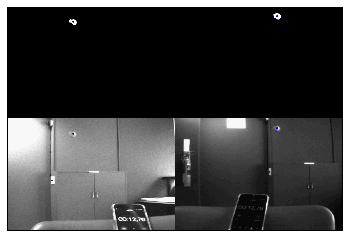

In [177]:
def view_image(i = 0):
    plt.imshow(result[i], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.show()

w = interact(view_image, i=(0, len(result)-1))

In [130]:
N = 100
print('SPEED TESTS\n')

print('Background Subtract Simple:\t %f ms' %((Speed_background_sub_simple.best*1000)/N))
print('Background Subtract MOG:\t %f ms' %((Speed_background_sub_mog.best*1000)/N))
print('Simple Thresholding:\t\t %f ms' %((Speed_thresh_simple.best*1000)/N))
print('Adaptive Thresholding:\t\t %f ms' %((Speed_thresh_adapt.best*1000)/N))
print('Otsu\'s Method Thresholding:\t %f ms' %((Speed_thresh_otsu.best*1000)/N))
print('Gaussian Blur:\t\t\t %f ms' %((Speed_gaussian.best*1000)/N))
print('Median Filter:\t\t\t %f ms' %((Speed_median.best*1000)/N))
print('Bilateral Filter:\t\t %f ms' %((Speed_bilateral.best*1000)/N))
print('Erosion:\t\t\t %f ms' %((Speed_erode.best*1000)/N))
print('Dilation:\t\t\t %f ms' %((Speed_dilate.best*1000)/N))
print('Contour Detection:\t\t %f ms' %((Speed_contour.best*1000)/N))

SPEED TESTS

Background Subtract Simple:	 0.126263 ms
Background Subtract MOG:	 3.011157 ms
Simple Thresholding:		 0.072582 ms
Adaptive Thresholding:		 5.275236 ms
Otsu's Method Thresholding:	 0.306732 ms
Gaussian Blur:			 0.145002 ms
Median Filter:			 0.548980 ms
Bilateral Filter:		 4.614971 ms
Erosion:			 0.144244 ms
Dilation:			 0.143171 ms
Contour Detection:		 0.355415 ms


In [49]:
0.123945 + 2.986745 + 0.072133 + 5.275236 + 0.306732 + 0.145002 + 0.548980 + 4.614971 + 0.144244 + 0.143171

14.361158999999999